# Train a from-scratch Embedding-Average MLP (simple + effective)

In [ ]:
# Cell 1 — Imports & setup
import os, math, random, json
from dataclasses import dataclass, asdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from transformers import BertTokenizerFast

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Reproducibility
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
# Cell 2 — Config
@dataclass
class CFG:
    csv_path: str = "Cleaned_Tickets.csv"
    text_cols: tuple = ("subject", "body_html")
    label_col: str = "department"

    model_name: str = "bert-base-cased"  # tokenizer
    max_length: int = 128

    train_bs: int = 64
    valid_bs: int = 128

    embed_dim: int = 300
    hidden_dim: int = 512
    dropout: float = 0.30

    lr: float = 1e-3
    weight_decay: float = 1e-4
    num_epochs: int = 50
    patience: int = 4      # early stopping on macro-F1
    clip_norm: float = 1.0

    use_class_weights: bool = True
    use_weighted_sampler: bool = False

CFG = CFG()
CFG


CFG(csv_path='customer_support_tickets.csv', text_cols=('subject', 'body_html'), label_col='department', model_name='bert-base-cased', max_length=128, train_bs=64, valid_bs=128, embed_dim=300, hidden_dim=512, dropout=0.3, lr=0.001, weight_decay=0.0001, num_epochs=50, patience=4, clip_norm=1.0, use_class_weights=True, use_weighted_sampler=False)

In [ ]:
# Cell 3 — Load & prepare text
df = pd.read_csv(CFG.csv_path)

# Build a single text field from available columns
if set(CFG.text_cols).issubset(df.columns):
    a, b = CFG.text_cols
    df["text"] = (df[a].fillna("") + " " + df[b].fillna("")).str.strip()
elif {"subject","body"}.issubset(df.columns):
    df["text"] = (df["subject"].fillna("") + " " + df["body"].fillna("")).str.strip()
elif "text" in df.columns:
    pass
else:
    raise ValueError("Could not find text columns. Update CFG.text_cols or add logic to create df['text'].")

# Keep rows with both text and label
df = df.dropna(subset=["text", CFG.label_col]).copy()
df = df[df["text"].str.len() > 0].copy()

df[[CFG.label_col, "text"]].head(3)


,department,text
0,Technical Support,"Account Disruption Dear Customer Support Team,..."
1,Returns and Exchanges,Query About Smart Home System Integration Feat...
2,Billing and Payments,Inquiry Regarding Invoice Details Dear Custome...


In [ ]:
# Cell 4 — Labels & splits
le = LabelEncoder()
df["label_id"] = le.fit_transform(df[CFG.label_col].astype(str))
num_classes = len(le.classes_)
print("Classes:", num_classes, "→", list(le.classes_))

train_df, test_df = train_test_split(
    df, test_size=0.10, random_state=SEED, stratify=df["label_id"]
)
train_df, val_df = train_test_split(
    train_df, test_size=0.10, random_state=SEED, stratify=train_df["label_id"]
)

len(train_df), len(val_df), len(test_df)


Classes: 10 → ['Billing and Payments', 'Customer Service', 'General Inquiry', 'Human Resources', 'IT Support', 'Product Support', 'Returns and Exchanges', 'Sales and Pre-Sales', 'Service Outages and Maintenance', 'Technical Support']


(13232, 1471, 1634)

In [ ]:
# Cell 5 — Tokenizer & dataset
tokenizer = BertTokenizerFast.from_pretrained(CFG.model_name)
pad_id = tokenizer.pad_token_id

class TicketDeptDS(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(
            str(self.texts[idx]),
            truncation=True, max_length=self.max_length,
            padding="max_length", return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

train_ds = TicketDeptDS(train_df["text"], train_df["label_id"], tokenizer, CFG.max_length)
val_ds   = TicketDeptDS(val_df["text"],   val_df["label_id"],   tokenizer, CFG.max_length)
test_ds  = TicketDeptDS(test_df["text"],  test_df["label_id"],  tokenizer, CFG.max_length)

if CFG.use_weighted_sampler:
    counts = train_df["label_id"].value_counts().to_dict()
    w_per_class = {c: 1.0 / counts[c] for c in counts}
    sample_w = train_df["label_id"].map(w_per_class).astype(np.float64).values
    sampler = WeightedRandomSampler(
        weights=torch.as_tensor(sample_w, dtype=torch.double),
        num_samples=len(sample_w),
        replacement=True
    )
    train_loader = DataLoader(train_ds, batch_size=CFG.train_bs, sampler=sampler, num_workers=2, pin_memory=True)
else:
    train_loader = DataLoader(train_ds, batch_size=CFG.train_bs, shuffle=True,  num_workers=2, pin_memory=True)

val_loader  = DataLoader(val_ds,  batch_size=CFG.valid_bs, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=CFG.valid_bs, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds), pad_id


(13232, 1471, 1634, 0)

In [ ]:
# Cell 6 — Class weights
if CFG.use_class_weights:
    cls_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.arange(num_classes),
        y=train_df["label_id"].values
    )
    class_weights = torch.tensor(cls_weights, dtype=torch.float, device=device)
    pd.Series(cls_weights, index=le.classes_).sort_values(ascending=False).head(10)
else:
    class_weights = None
    print("Class weights disabled.")


In [ ]:
# Cell 7 — Model (scratch)
class DeptAvgMLP(nn.Module):
    def __init__(self, vocab_size, pad_id, num_classes, embed_dim=300, hidden_dim=512, p_dropout=0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        nn.init.normal_(self.embed.weight, mean=0.0, std=0.02)
        self.ln = nn.LayerNorm(embed_dim)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p_dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        with torch.no_grad():
            self.embed.weight[pad_id].zero_()

    def forward(self, input_ids, attention_mask):
        x = self.embed(input_ids)
        x = self.ln(x)
        mask = attention_mask.unsqueeze(-1).float()
        avg = (x * mask).sum(1) / mask.sum(1).clamp(min=1.0)
        h = self.relu(self.fc1(avg))
        h = self.dropout(h)
        return self.fc2(h)

model = DeptAvgMLP(
    vocab_size=tokenizer.vocab_size,
    pad_id=pad_id,
    num_classes=num_classes,
    embed_dim=CFG.embed_dim,
    hidden_dim=CFG.hidden_dim,
    p_dropout=CFG.dropout
).to(device)

sum(p.numel() for p in model.parameters())/1e6


8.858642

In [ ]:
# Cell 8 — Optim, loss, sched, early stop
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2, threshold=1e-4)

ce_loss = nn.CrossEntropyLoss(weight=class_weights) if CFG.use_class_weights else nn.CrossEntropyLoss()

class EarlyStopping:
    def __init__(self, patience=CFG.patience, mode="max", delta=0.0):
        self.patience = patience; self.mode = mode; self.delta = delta
        self.best = None; self.bad_epochs = 0; self.should_stop = False
    def step(self, metric):
        if self.best is None: self.best = metric; return
        improved = (metric > self.best + self.delta) if self.mode=="max" else (metric < self.best - self.delta)
        if improved: self.best = metric; self.bad_epochs = 0
        else:
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                self.should_stop = True

early_stopper = EarlyStopping()


In [ ]:
# Cell 9 — Train/Eval helpers
def train_epoch(loader):
    model.train()
    total_loss = 0.0
    for batch in loader:
        ids  = batch["input_ids"].to(device, non_blocking=True)
        mask = batch["attention_mask"].to(device, non_blocking=True)
        labs = batch["labels"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(ids, mask)
        loss = ce_loss(logits, labs)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=CFG.clip_norm)
        optimizer.step()

        total_loss += loss.item()
    return total_loss / max(1, len(loader))

@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    total_loss = 0.0
    all_preds, all_true = [], []
    for batch in loader:
        ids  = batch["input_ids"].to(device, non_blocking=True)
        mask = batch["attention_mask"].to(device, non_blocking=True)
        labs = batch["labels"].to(device, non_blocking=True)
        logits = model(ids, mask)
        loss = ce_loss(logits, labs)
        total_loss += loss.item()
        all_preds.append(logits.argmax(-1).cpu().numpy())
        all_true.append(labs.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    f1w = f1_score(y_true, y_pred, average="weighted")
    return {"loss": total_loss / max(1, len(loader)),
            "accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w,
            "y_true": y_true, "y_pred": y_pred}


In [ ]:
# Cell 10 — Train loop
best_f1 = -1.0
ckpt_path = "dept_avgmlp_best.pt"
history = {"train_loss": [], "val_loss": [], "val_f1": []}

for epoch in range(1, CFG.num_epochs + 1):
    print(f"\n→ Epoch {epoch}/{CFG.num_epochs}")
    tr_loss = train_epoch(train_loader)
    val_res = eval_epoch(val_loader)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_res["loss"])
    history["val_f1"].append(val_res["f1_macro"])

    # LR scheduler on macro-F1
    scheduler.step(val_res["f1_macro"])

    # Checkpoint if improved
    if val_res["f1_macro"] > best_f1:
        best_f1 = val_res["f1_macro"]
        torch.save(model.state_dict(), ckpt_path)
        print(f"  ✔ New best macro-F1={best_f1:.4f} — checkpoint saved.")

    print(f"  Train Loss: {tr_loss:.4f} | Val Loss: {val_res['loss']:.4f} | "
          f"Acc: {val_res['accuracy']:.4f} | F1(macro): {val_res['f1_macro']:.4f} | "
          f"F1(weighted): {val_res['f1_weighted']:.4f}")

    early_stopper.step(val_res["f1_macro"])
    if early_stopper.should_stop:
        print("  Early stopping triggered.")
        break

# Load best before testing
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()



→ Epoch 1/50
  ✔ New best macro-F1=0.2660 — checkpoint saved.
  Train Loss: 1.8929 | Val Loss: 1.7108 | Acc: 0.2889 | F1(macro): 0.2660 | F1(weighted): 0.2867

→ Epoch 2/50
  ✔ New best macro-F1=0.4007 — checkpoint saved.
  Train Loss: 1.2664 | Val Loss: 1.6095 | Acc: 0.4140 | F1(macro): 0.4007 | F1(weighted): 0.4202

→ Epoch 3/50
  ✔ New best macro-F1=0.4218 — checkpoint saved.
  Train Loss: 0.9293 | Val Loss: 1.5882 | Acc: 0.4215 | F1(macro): 0.4218 | F1(weighted): 0.4246

→ Epoch 4/50
  ✔ New best macro-F1=0.4489 — checkpoint saved.
  Train Loss: 0.7441 | Val Loss: 1.7174 | Acc: 0.4473 | F1(macro): 0.4489 | F1(weighted): 0.4518

→ Epoch 5/50
  ✔ New best macro-F1=0.4761 — checkpoint saved.
  Train Loss: 0.6141 | Val Loss: 1.8354 | Acc: 0.4663 | F1(macro): 0.4761 | F1(weighted): 0.4671

→ Epoch 6/50
  Train Loss: 0.5330 | Val Loss: 2.0443 | Acc: 0.4596 | F1(macro): 0.4516 | F1(weighted): 0.4580

→ Epoch 7/50
  Train Loss: 0.4673 | Val Loss: 2.2338 | Acc: 0.4697 | F1(macro): 0.4581 |

DeptAvgMLP(
  (embed): Embedding(28996, 300, padding_idx=0)
  (ln): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=300, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
# Cell 12 — Save artifacts
ART_DIR = "artifacts/dept_avgmlp_v1"
os.makedirs(ART_DIR, exist_ok=True)

# 1) model weights
torch.save(model.state_dict(), f"{ART_DIR}/pytorch_model.bin")

# 2) label classes
with open(f"{ART_DIR}/label_classes.json", "w") as f:
    json.dump(le.classes_.tolist(), f)

# 3) cfg
with open(f"{ART_DIR}/cfg.json", "w") as f:
    json.dump(asdict(CFG), f, indent=2)

# 4) tokenizer
tokenizer.save_pretrained(ART_DIR)

print("Saved:", os.listdir(ART_DIR))


Saved: ['vocab.txt', 'label_classes.json', 'tokenizer_config.json', 'cfg.json', 'pytorch_model.bin', 'special_tokens_map.json', 'tokenizer.json']


Test metrics: {'loss': 3.76, 'accuracy': 0.6151, 'f1_macro': 0.5915, 'f1_weighted': 0.6143}

Classification report (test):
                                 precision    recall  f1-score   support

           Billing and Payments       0.81      0.84      0.82       160
               Customer Service       0.58      0.59      0.58       241
                General Inquiry       0.43      0.54      0.48        24
                Human Resources       0.51      0.60      0.55        35
                     IT Support       0.57      0.53      0.55       194
                Product Support       0.61      0.52      0.56       307
          Returns and Exchanges       0.50      0.65      0.57        82
            Sales and Pre-Sales       0.52      0.51      0.51        51
Service Outages and Maintenance       0.65      0.62      0.64        66
              Technical Support       0.64      0.66      0.65       474

                       accuracy                           0.62      1634

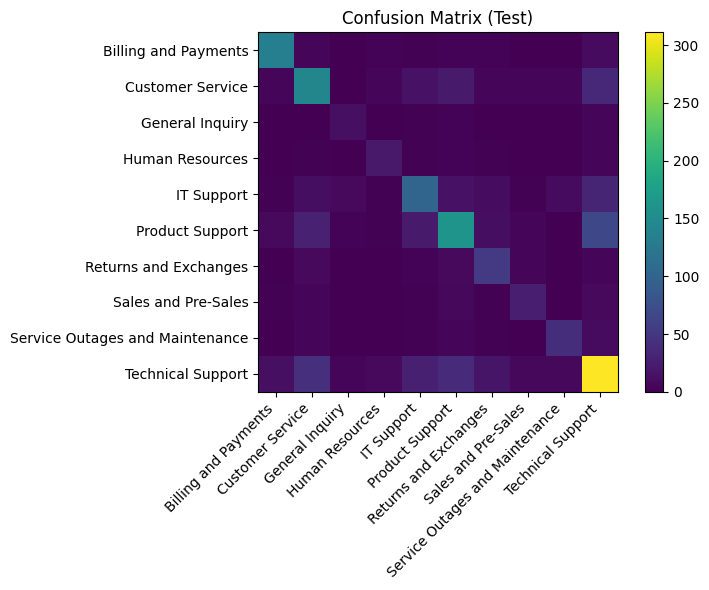

In [ ]:
# Cell 11 — Test eval & confusion matrix
test_res = eval_epoch(test_loader)
print("Test metrics:", {k: round(v, 4) for k, v in test_res.items() if isinstance(v, (float, int))})

print("\nClassification report (test):")
print(classification_report(test_res["y_true"], test_res["y_pred"], target_names=le.classes_))

cm = confusion_matrix(test_res["y_true"], test_res["y_pred"])
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix (Test)")
plt.colorbar(im, ax=ax)
ax.set_xticks(np.arange(num_classes)); ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(le.classes_, rotation=45, ha="right"); ax.set_yticklabels(le.classes_)
plt.tight_layout(); plt.show()


In [ ]:
# Cell 13 — Reload for inference
ART_DIR = "artifacts/dept_avgmlp_v1"

# Load tokenizer & classes
tokenizer = BertTokenizerFast.from_pretrained(ART_DIR)
with open(f"{ART_DIR}/label_classes.json") as f:
    classes = json.load(f)

with open(f"{ART_DIR}/cfg.json") as f:
    cfg_loaded = json.load(f)

pad_id = tokenizer.pad_token_id
num_classes = len(classes)

model = DeptAvgMLP(
    vocab_size=tokenizer.vocab_size,
    pad_id=pad_id,
    num_classes=num_classes,
    embed_dim=cfg_loaded["embed_dim"],
    hidden_dim=cfg_loaded["hidden_dim"],
    p_dropout=cfg_loaded["dropout"]
).to(device)

state_dict = torch.load(f"{ART_DIR}/pytorch_model.bin", map_location=device)
model.load_state_dict(state_dict)
model.eval()

# Inference helper
@torch.no_grad()
def predict_department(texts, max_length=cfg_loaded["max_length"]):
    enc = tokenizer(
        texts if isinstance(texts, list) else [texts],
        truncation=True, max_length=max_length,
        padding="max_length", return_tensors="pt"
    )
    logits = model(enc["input_ids"].to(device), enc["attention_mask"].to(device))
    preds = logits.argmax(-1).cpu().numpy().tolist()
    return [classes[p] for p in preds]

predict_department(["My invoice is wrong and payment failed", "VPN disconnects after update"])


['Billing and Payments', 'Product Support']

# From-Scratch Model - .pt

In [ ]:
# Colab setup: installs + imports + device
!pip -q install transformers==4.41.2 torch torchvision torchaudio scikit-learn

import os, json, numpy as np, torch, torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizerFast, AutoConfig, AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

device(type='cuda')

In [ ]:
# Cell 2 — Point to your checkpoint file
MLP_PT = "department_model.pt"   # <- change if your filename differs
assert os.path.exists(MLP_PT), "Upload department.pt to Colab first!"


In [ ]:
# Cell 3 — Define the DeptAvgMLP architecture (must match training)
class DeptAvgMLP(nn.Module):
    def __init__(self, vocab_size, pad_id, num_classes, embed_dim=300, hidden_dim=512, p_dropout=0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        nn.init.normal_(self.embed.weight, mean=0.0, std=0.02)
        self.ln = nn.LayerNorm(embed_dim)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p_dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.embed(input_ids)
        x = self.ln(x)
        mask = attention_mask.unsqueeze(-1).float()
        avg = (x * mask).sum(1) / mask.sum(1).clamp(min=1.0)
        h = self.relu(self.fc1(avg))
        h = self.dropout(h)
        return self.fc2(h)


In [ ]:
# Cell 4 — Load state_dict and infer dims
obj = torch.load(MLP_PT, map_location="cpu")
state_dict = obj["model_state_dict"] if isinstance(obj, dict) and "model_state_dict" in obj else obj

# Infer dimensions from weights
vocab_size, embed_dim = state_dict["embed.weight"].shape
hidden_dim = state_dict["fc1.weight"].shape[0]
num_classes = state_dict["fc2.weight"].shape[0]
print(dict(vocab_size=vocab_size, embed_dim=embed_dim, hidden_dim=hidden_dim, num_classes=num_classes))


{'vocab_size': 28996, 'embed_dim': 300, 'hidden_dim': 512, 'num_classes': 10}


In [ ]:
# Cell 5 — Rebuild tokenizer & model skeleton, then load weights
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
pad_id = tokenizer.pad_token_id

model = DeptAvgMLP(
    vocab_size=vocab_size, pad_id=pad_id, num_classes=num_classes,
    embed_dim=embed_dim, hidden_dim=hidden_dim, p_dropout=0.3
).to(device)

model.load_state_dict(state_dict, strict=True)
model.eval()
print("Model ready.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Model ready.


In [ ]:
# Cell 6 — Load class names (if you saved them), else fallback (optional)
classes = None
for cand in ["label_classes.json", "artifacts/dept_avgmlp_v1/label_classes.json"]:
    if os.path.exists(cand):
        with open(cand) as f: classes = json.load(f)
        print("Loaded classes from:", cand)
        break

if classes is None and os.path.exists("Cleaned_Tickets.csv"):
    import pandas as pd
    df = pd.read_csv("Cleaned_Tickets.csv")
    le = LabelEncoder().fit(df["department"].astype(str))
    classes = le.classes_.tolist()
    print("Rebuilt classes from CSV (order must match training encoder).")


In [ ]:
# Cell 7 — Inference helpers
import torch.nn.functional as F

@torch.no_grad()
def predict_mlp(texts, max_length=128, topk=1):
    enc = tokenizer(
        texts if isinstance(texts, list) else [texts],
        truncation=True, max_length=max_length,
        padding="max_length", return_tensors="pt",
    )
    logits = model(enc["input_ids"].to(device), enc["attention_mask"].to(device))
    probs = F.softmax(logits, dim=-1).cpu().numpy()
    idxs = np.argsort(-probs, axis=1)[:, :topk]
    if classes:
        labels = [[(classes[j], float(probs[i, j])) for j in idxs[i]] for i in range(len(idxs))]
    else:
        labels = [[(int(j), float(probs[i, j])) for j in idxs[i]] for i in range(len(idxs))]
    return labels

predict_mlp(["Invoice not matching, refund requested", "Wi-Fi disconnects frequently"], topk=3)


[[(0, 1.0), (9, 2.2562149436674944e-18), (5, 1.440222982875012e-18)],
 [(9, 0.9985817670822144),
  (8, 0.0007357488502748311),
  (5, 0.0006824314477853477)]]

In [ ]:
import torch

def show_weights(path):
    obj = torch.load(path, map_location="cpu")
    sd = obj["model_state_dict"] if isinstance(obj, dict) and "model_state_dict" in obj else obj
    print("Total tensors:", len(sd))
    for k, v in list(sd.items())[:8]:
        print(k, tuple(v.shape))
    total_params = sum(p.numel() for p in sd.values())
    print("Total parameters:", f"{total_params:,}")

show_weights("department_model.pt")


Total tensors: 7
embed.weight (28996, 300)
ln.weight (300,)
ln.bias (300,)
fc1.weight (512, 300)
fc1.bias (512,)
fc2.weight (10, 512)
fc2.bias (10,)
Total parameters: 8,858,642
